Convergenza del fit: True


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.02 (χ²/ndof = 0.5)      │              Nfcn = 504              │
│ EDM = 5.05e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │  2.32e3   │  0.11e3   │            │            │    0    │         │       │
│ 1 │ mu           │   9.97    │   0.08    │            │            │         │         │       │
│ 2 │ sigma        │   2.10    │   0.08    │            │            │    0    │         │       │
│ 3 │ N_background │  7.84e3   │  0.14e3   │            │            │    0    │         │       │
│ 4 │ tau          │   5.10    │   0.12    │            │            │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │     1.22e+04       -3.046        6.301     -0.011e6       -8.641 │
│           mu │       -3.046      0.00639       -0.003        3.240        0.001 │
│        sigma │        6.301       -0.003      0.00721       -7.064       -0.005 │
│ N_background │     -0.011e6        3.240       -7.064     2.07e+04       10.428 │
│          tau │       -8.641        0.001       -0.005       10.428       0.0132 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

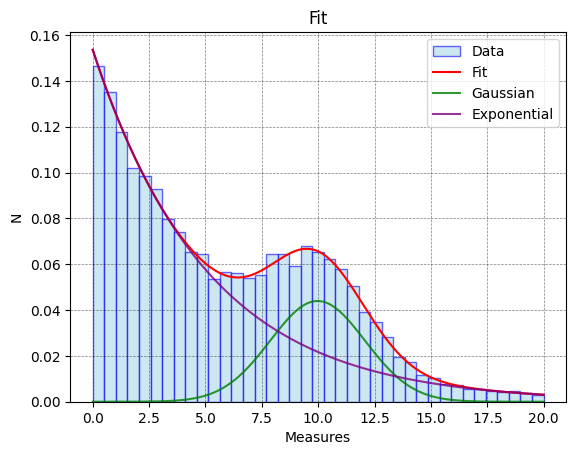

In [6]:
# Write a program that fits the events saved in the file dati.txt.
# (1) Take care to determine the range and binning of the histogram used for the fit based on the events themselves, 
#      writing appropriate algorithms to determine the minimum and maximum of the sample and a reasonable estimate
#      of the number of bins to use.
# (2) Determine the initial values of the fit parameters using the techniques described in the lesson.
# (3) Print the fit result on the screen.
# (4) Plot the histogram with the fitted model overlaid.
# (5) Which parameters are correlated, and which are anti-correlated with each other?

import numpy as np
from iminuit import Minuit
from iminuit.cost import ExtendedBinnedNLL
from IPython.display import display
import scipy.stats as sci
import matplotlib.pyplot as plt

def model_total_function (bin_edges, N_signal, mu, sigma, N_background, tau): 
    # è una cdf, quindi bin edges è un intervallo [xi , x(i+1)]
    return N_signal*sci.norm.cdf(bin_edges, mu, sigma) + N_background*sci.expon.cdf(bin_edges, 0, tau)

def fit_function (x, N_signal, mu, sigma, N_background, tau): 
    # è una cdf, quindi bin edges è un intervallo [xi , x(i+1)]
    return N_signal*sci.norm.pdf(x, mu, sigma) + N_background*sci.expon.pdf(x, 0, tau)

# ----------------------------------------------------------------- #

data = np.loadtxt('dati.txt')
max_data = np.max(data)
min_data = np.min(data)
bin_edges = np.linspace(min_data, max_data, 40)
bin_content, bin_edges = np.histogram(data, bin_edges) # number of event per bin
    
my_cost_func = ExtendedBinnedNLL(bin_content, bin_edges, model_total_function)
my_minuit = Minuit(my_cost_func,
                N_signal = sum(data), mu = np.mean(data), sigma = np.std(data), # signal input parameters
                N_background = sum(data), tau = 1.)                             # background input parameters
my_minuit.limits['N_signal', 'N_background', 'sigma', 'tau'] = (0, None)  
    
    # SIGNAL FROZEN, BACKGROUND FREE
my_minuit.values["N_signal"] = 0
my_minuit.fixed["N_signal", "mu", "sigma"] = True
    
bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
my_cost_func.mask = (bin_centres < 5) | (15 < bin_centres)

my_minuit.migrad ()
    
    # SIGNAL FREE, BACKGROUND FROZEN
my_cost_func.mask = None # remove mask
my_minuit.fixed = False # release all parameters
my_cost_func.mask = (bin_centres > 5) & (15 > bin_centres)
my_minuit.fixed["N_background", "tau"] = True # fix background parameters
my_minuit.values["N_signal"] = sum(data) - my_minuit.values["N_background"] # do not start at the limit
my_minuit.migrad ()
    
    # FINAL FIT
my_cost_func.mask = None
my_minuit.fixed = False # release all parameters
    
my_minuit.migrad ()
print (f'Convergenza del fit: {my_minuit.valid}')
display (my_minuit)
    
    # PLOTS
N_signal_fit = my_minuit.values[0]
mu_fit = my_minuit.values[1]
sigma_fit = my_minuit.values[2] 
N_background_fit = my_minuit.values[3]
tau_fit = my_minuit.values[4]
    
x_coord = np.linspace(min_data, max_data, 10000)
y_f = []
y_gauss = []
y_exp = []
for i in range(len(x_coord)):
    y_f.append(fit_function(x_coord[i], N_signal_fit, mu_fit, sigma_fit, N_background_fit, tau_fit))
    y_gauss.append(N_signal_fit*sci.norm.pdf(x_coord[i], mu_fit, sigma_fit))
    y_exp.append(N_background_fit*sci.expon.pdf(x_coord[i], 0, tau_fit))
        
fig, ax = plt.subplots(1,1)
ax.hist(data, bins=bin_edges, color='lightblue', label='Data', edgecolor='blue', alpha=0.6, density=True)
ax.plot(x_coord, np.array(y_f)/len(data), color='red', label='Fit')
ax.plot(x_coord, np.array(y_gauss)/len(data), color='green', alpha=0.8, label='Gaussian')
ax.plot(x_coord, np.array(y_exp)/len(data), color='purple', alpha=0.8, label='Exponential')
ax.set_xlabel('Measures')
ax.set_ylabel('N')
ax.set_title('Fit')
ax.legend()
ax.grid(color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    
plt.show()
